# Bioreactor NPZ Model
Model to simulate algae, nutrient and grazer dynamics in a chemostat process, i.e. a bioreactor with continous population dilution and renewal of nutrients.  

Experiments with a flexible bioreactor mixed by artificial wave conditions were run in 2016. A BG11 medium (photo-autotrophic growth medium) was inoculated with *Chlamydomonas reinhardtii*. Algae biomass was tracked through daily turbidity readings. Turbidity was converted to mg C/L using a lab derived relationship. After initial growth of algae, the population collapsed (see figure). Microscopic sample examination showed the presence of rotifers, which very likely grazed on the algae and caused the population collapse. This model simulates the algae population (P), their nutrient source in form of phosphorus (N), and the rotifer population (Z). The model corresponds to a chemostat model where dilution represents drawing a fixed sample volume every day and replacing the volume with nutrient medium.

## Read and show data from experiment

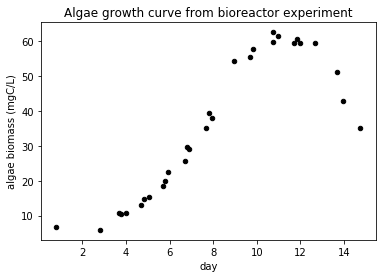

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
turb = pd.read_csv('exp1_turbidity.csv')
turb.plot.scatter(x = 'day', y = 'turbidity_as_mgC_L', c = 'black', 
                  title = 'Algae growth curve from bioreactor experiment').set_ylabel('algae biomass (mgC/L)'); 
#semicolon at end suppresses additional output

## Model description

The model consists of three ordinary coupled differential equations. The algal population (P) is described by nutrient dependent growth following a Monod kinetic. Losses of algae are through grazing and dilution based on sampling. Dilution corresponds to mortality for both algae and their grazers and to nutrient renewal. Initial conditions for P and N were inferred from the experimental set up. Nutrients represent phosphorous, which was 5 mg P/L for standard BG11 medium, a medium for photo-autotrophic growth. Initial nutrient concentration was set lower than in the medium, since it was diluted when filling the bioreactor. Carbon biomass was converted to phosphorus using a derived P:C ratio of 0.07 (atomar, from the experiment) which was a bit higher than the Redfield ratio (molar C:P of 106:1 corresponds to 0.024 atomar P:C). 
Initial biomass of grazers was adjusted during for model parametrisation, but was assuemd to be close to  0.3 mg C/L. Dry weight of rotifers ranges between approximately 0.1-1 $\mu$g per individual which corresponds to 0.05-0.5 $\mu$g carbon (assuming carbon biomass as 1/2 dry weight). The total volume of the bioreactor is 15 L. An inoculum of just one rotifer (or one egg?) into the system would correspond to approximately 0.05-0.5 $\mu$gC/15L/1000 = 0.33-3.3 10$^{-5}$ mg C/L. Growth rate, dilution rate, and nutrient to carbon ratio of algae were determined during the experiment. Grazing rate, growth efficiency and half-saturation constant were adjusted and used to fit the model to the data.

### Parameters
- `r0` - growth rate of algae (per day)
- `g` - grazing rate of rotifers (per biomass/per day)
- `e` - growth efficiency of rotifers (relative)
- `d` - dilution rate (per day) 
- `a` - nutrient to carbon ratio of algae
- `k` - half-saturation constant for algae growth dependent on N (mgP/L) 
- `Nin` - nutrient concentration in medium (mgP/L)

### Equations

growth rate: $r = r0 \frac{N}{(N+k)}$

$\frac{dN}{dt} = -a r P - d N + d Nin$

$\frac{dP}{dt} = r P - g P Z - d P$

$\frac{dZ}{dt} = g e P Z - d Z$

## Model implementation

In [40]:
import numpy as np
from scipy import integrate

def NPZmodel(par,initial_cond,start_t,end_t,incr):
    '''
    Function to solve the NPZ model, takes following arguments.
    par: list with parameter values
    initial_cond: list with initial values
    start_t: start time
    end_t: end time
    incr: increments for building time vector 
    returns: list with solutions and time
    '''
    #-time-grid-----------------------------------
    t = np.linspace(start_t, end_t,incr)
    #differential-eq-system----------------------
    def eq(y,t):
        '''
        Function with definition of the differential equations,
        see help for integrate.odeint from module scipy for conventions for arguments
        '''
        N=y[0]  #nutrients
        P=y[1]  #algae
        Z=y[2]  #rotifers
        r0,g,e,d,a,k,Nin = par   
        # the model equations   
        r = r0 * N/(N+k)
        f0 = -a*r*P - d*N + d*Nin
        f1 = r*P - g*P*Z - d*P
        f2 = g*e*P*Z - d*Z
        return [f0, f1, f2]

    #integrate------------------------------------
    ds = integrate.odeint(eq,initial_cond,t)
    return (ds[:,0],ds[:,1],ds[:,2],t)

## Define parameters

In [49]:
r0 = 0.33   
g = 0.2
e = 0.15  
d = 0.013
a = 0.07
k = 0.05   
Nin = 5   
# list with parameters
rates = [r0,g,e,d,a,k,Nin]

## Initial conditions

In [50]:
N0 = 4                 # initial nutrient concentration (mgP/L)
P0 = 3.5               # initial algal biomass (mgC/L)
Z0 = 0.2 * 10**(-5)    # initial grazer biomass (mgC/L)
# list with initial conditions
y0 = [N0, P0, Z0]  

## Run model

In [51]:
F0,F1,F2,T = NPZmodel(par=rates, initial_cond=y0, start_t=0, end_t=16, incr=16*6)

## Show results

Text(0.5, 1.0, 'Algae Chemostat with Grazers')

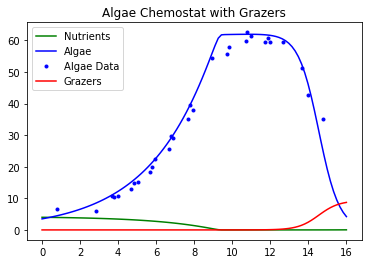

In [52]:
plt.figure()
plt.plot(T,F0,'-g', T,F1,'-b', turb.day,turb.turbidity_as_mgC_L,'.b', T,F2,'-r')
plt.legend(('Nutrients', 'Algae', 'Algae Data','Grazers'), loc='best')
plt.title('Algae Chemostat with Grazers')

The model is able to describe the growth and collapse of the algae population.